# Measuring audio quality

This notebook provides some simple computational methods to roughly estimate the quality or intelligibility of an audio recording.
Perceptual quality is a difficult concept to pin down precisely, but we'll be using two methods to estimate different aspects of audio
that influence quality: *spectral roll-off* and *spectral contrast*.

## Preliminaries: spectrograms

We begin by assuming that an audio signal `y` has already been transformed into a magnitude spectrogram `S`, so that the matrix entry `S[f, t]` measures the amount of energy at frequency index `f` and time index `t`.  Each column `S[:, t]` (also known as a *frame*) corresponds to the discrete Fourier transform magnitudes of a short excerpt centered around time index `t`.  Both of the methods we'll use below work independently on each frame, and the results can be aggregated to summarize the entire clip.

## Spectral roll-off

The **spectral roll-off** is defined as the frequency `f` at which some given percentage of the total energy is contained at frequencies `f' <= f`.  Higher roll-off values correspond to higher frequency content, which may sound *crisper* or *brighter*, while lower roll-off values mean there is little or no content at high frequencies, leading to a muffled sound.  Typical percentage values for roll-off are 85% or 95%.

As a general rule, the *sampling rate* of the audio in question (typically 44100 Hz for CD-quality audio) dictates an upper bound on frequency content: there can never be energy for a frequency larger than half the sampling rate (e.g., 22050 Hz).  However, it is common for audio to be resampled or converted to different formats, so the true cut-off frequency might be much lower than half the sampling rate in general.  Spectral roll-off gives a robust way to measure this property independent of the file's sampling rate.

## Spectral contrast

Audio can also sound muffled if there is not a sufficient difference in *loudness* between the foreground (e.g., voice) and background (e.g., noise).  The **spectral contrast** feature tries to measure this in a way that is agnostic to the sources of sound.  It proceeds by first breaking the frequency range into octaves.  For each octave (say, 100 Hz to 200 Hz), the distribution of energies is measured, and the contrast is estimated by comparing the highest energy to the lowest energy observed within the octave (in decibels).  (More precisely, percentile estimates are used, but you may think of it as maximum and minimum to get the intuition.)

Concretely, if you have a pure tone with no background noise, then it will have a high contrast.  If you have broad-band noise (e.g., wind or running water), then there will be little distinction between the highest and lowest energy values, and it will have low-contrast.

As contrast is computed independently per-octave, it returns a list of measurements for each time index.  For our purposes, we will restrict attention to a set of octaves covering the typical range of human voice (about 85 Hz to 3000 Hz).

In [1]:
# This cell sets up our environment
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio

In [2]:
# Let's load in a clean audio example
y, sr = librosa.load('clean-speech.wav')
#y, sr = librosa.load('noisy-speech.wav')

In [3]:
# We can listen to it in the notebook
Audio(data=y, rate=sr)

In [4]:
# And compute its short-time Fourier transform (STFT) spectrogram
# We use np.abs to take just the magnitude, and discard the phase information
S = np.abs(librosa.stft(y))

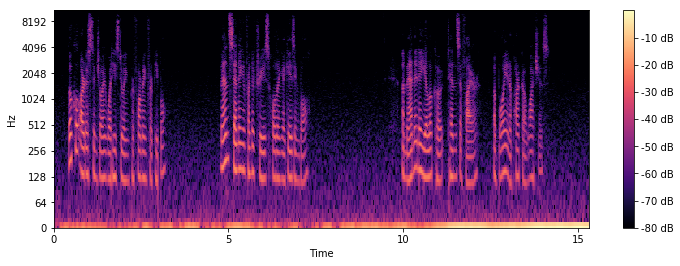

In [5]:
# Let's visualize it with a logarithmic frequency axis
plt.figure(figsize=(12, 4))
# Setting rasterized=True makes plotting less accurate, but faster
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), x_axis='time', y_axis='log', rasterized=True)
plt.colorbar(format='%2g dB')

In [6]:
# Let's first compute the spectral roll-off at 85%

rolloff = librosa.feature.spectral_rolloff(S=S, roll_percent=0.85)

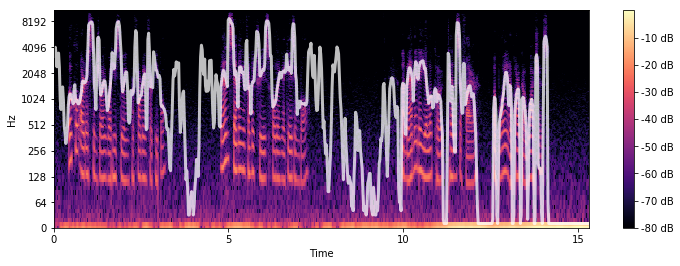

In [7]:
# We can plot the roll-off over the spectrogram by copying the plot from above...

plt.figure(figsize=(12, 4))
# Setting rasterized=True makes plotting less accurate, but faster
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), x_axis='time', y_axis='log', rasterized=True)
plt.colorbar(format='%2g dB')

# And drawing on top of it
times = librosa.times_like(rolloff)
plt.plot(times, rolloff[0], color='w', linewidth=3, alpha=0.75)

## Spectral roll-off

As you can see from the plot, the white line roughly traces out the upper limit of where energy appears in the spectrum at each time index.

You have several options for aggregating this information across time, if you want a single number summarizing roll-off.
Simple averaging may not be a good idea, as it will be influenced by regions of silence.
For most applications, a percentile estimate is probably appropriate, eg, the 95th percentile across time.
This will be robust to regions of silence, as well as sporadic clicks or pops that might occur as recording or encoding artifacts.

In [8]:
total_rolloff = np.percentile(rolloff, 95)
print('Total roll-off: {:.2f} Hz'.format(total_rolloff))

Total roll-off: 5988.92 Hz


### Exercise


What happens if you change the roll-off to 95%?  Try it out!

---

In [9]:
# Now let's move on to spectral contrast.
# We'll use 5 octave bands starting at 80
# The method will then add an extra band that covers everything below the first frequency
#     0 --    80 (added automatically)
#    80 --   160
#   160 --   320
#   320 --   640
#   640 --  1280
#  1280 --  2560

contrast = librosa.feature.spectral_contrast(S=S, fmin=80, n_bands=5)

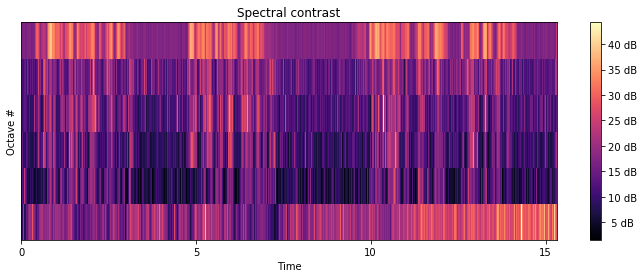

In [10]:
# We can plot it using specshow, but note that the vertical axis
# is now octaves, not frequencies
plt.figure(figsize=(12, 4))
# Setting rasterized=True makes plotting less accurate, but faster
librosa.display.specshow(contrast, x_axis='time', rasterized=True)
plt.ylabel('Octave #')
plt.title('Spectral contrast')
plt.colorbar(format='%2g dB')

In [11]:
# The bottom band covers frequencies below the human voice range
# We can do this by slicing the array to get rid of the first row
contrast = contrast[1:, :]

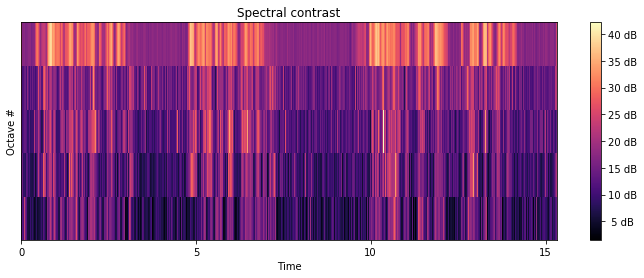

In [12]:
# And plot it once more
plt.figure(figsize=(12, 4))
librosa.display.specshow(contrast, x_axis='time', rasterized=True)
plt.ylabel('Octave #')
plt.title('Spectral contrast')
plt.colorbar(format='%2g dB')

## Contrast

From the contrast plot, we can see that contrast is low (darker color) at the bottom octave (where the noise is louder) and higher in the higher octaves (where noise tapers off).
However, contrast is only really high when the speaker is active and there is a reliable foreground sound.
This suggests that aggregation over time should be treated with care, just as before with roll-off.

A quantile-based aggregation is reasonable here as well, depending on what proportion of time you expect there to be foreground activity in your recording.
In this case, the speaker is active for about half the time, so a median would make sense.

(Fancier schemes based on energy-weighted averages may also work, but take a bit more care to develop properly.)

In [13]:
# We'll use the 50th percentile (median) and aggregate over the time axis (1)
# This will give a time-aggregated estimate for each of our five octave bands
total_contrast = np.percentile(contrast, 50, axis=1)

In [14]:
print('Total contrast (dB): {}'.format(total_contrast))

Total contrast (dB): [10.14335564 11.72216458 13.94382161 16.11731818 22.10216646]


## Exercise

Run through all of the above again, but now using `noisy-speech.wav`.  Note how the features change!

# Wrapping up

This notebook demonstrated how to work through a couple of spectral features to get a sense of audio quality.

In the next step, we'll show how to visualize this data after running it over a collection of recordings!